In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
import seaborn as sns
from collections import Counter
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 10)
# https://stackoverflow.com/questions/4150171/how-to-create-a-density-plot-in-matplotlib

In [ ]:
df_train = pd.read_csv('data/train.csv', header=0)
df_test = pd.read_csv('data/test.csv', header=0)
submission = pd.read_csv('data/sample_submission.csv', header=0)

In [ ]:
df_train['train_flag'] = 1
df_test['train_flag'] = 0
df_test['Crop_Damage'] = 0
print(df_train.shape, df_test.shape)

df_data = pd.concat((df_train, df_test))
print(df_data.shape)

(88858, 11) (59310, 11)
(148168, 11)


In [ ]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_Damage')
feature_cols.remove('train_flag')
label_col = 'Crop_Damage'
print(feature_cols)

['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season']


In [ ]:
df_data['ID_value'] = df_data['ID'].apply(lambda x: x.strip('F')).astype('int')

In [ ]:
df_data = df_data.sort_values(['ID_value'])

In [ ]:
df_data = df_data.reset_index(drop=True)

In [ ]:
df_data['Soil_Type_Damage'] = df_data.sort_values(['ID_value']).groupby(['Soil_Type'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Estimated_Insects_Count_Damage'] = df_data.sort_values(['ID_value']).groupby(['Estimated_Insects_Count'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Crop_Type_Damage'] = df_data.sort_values(['ID_value']).groupby(['Crop_Type'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Pesticide_Use_Category_Damage'] = df_data.sort_values(['ID_value']).groupby(['Pesticide_Use_Category'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Season_Damage'] = df_data.sort_values(['ID_value']).groupby(['Season'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Soil_Type_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Soil_Type'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Estimated_Insects_Count_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Estimated_Insects_Count'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Crop_Type_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Crop_Type'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Pesticide_Use_Category_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Pesticide_Use_Category'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Season_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Season'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

In [ ]:
df_data.loc[df_data['train_flag'] == 0, 'Crop_Damage'] = -999

In [ ]:
df_data['Crop_Damage_lag1'] = df_data['Crop_Damage'].shift(fill_value=-999)
df_data['Estimated_Insects_Count_lag1'] = df_data['Estimated_Insects_Count'].shift(fill_value=-999)
df_data['Crop_Type_lag1'] = df_data['Crop_Type'].shift(fill_value=-999)
df_data['Soil_Type_lag1'] = df_data['Soil_Type'].shift(fill_value=-999)
df_data['Pesticide_Use_Category_lag1'] = df_data['Pesticide_Use_Category'].shift(fill_value=-999)
df_data['Number_Doses_Week_lag1'] = df_data['Number_Doses_Week'].shift(fill_value=-999)
df_data['Number_Weeks_Used_lag1'] = df_data['Number_Weeks_Used'].shift(fill_value=-999)
df_data['Number_Weeks_Quit_lag1'] = df_data['Number_Weeks_Quit'].shift(fill_value=-999)
df_data['Season_lag1'] = df_data['Season'].shift(fill_value=-999)

df_data['Crop_Damage_lag2'] = df_data['Crop_Damage'].shift(periods=2,fill_value=-999)
df_data['Estimated_Insects_Count_lag2'] = df_data['Estimated_Insects_Count'].shift(periods=2,fill_value=-999)
df_data['Crop_Type_lag2'] = df_data['Crop_Type'].shift(fill_value=-999)
df_data['Soil_Type_lag2'] = df_data['Soil_Type'].shift(fill_value=-999)
df_data['Pesticide_Use_Category_lag2'] = df_data['Pesticide_Use_Category'].shift(periods=2,fill_value=-999)
df_data['Number_Doses_Week_lag2'] = df_data['Number_Doses_Week'].shift(periods=2,fill_value=-999)
df_data['Number_Weeks_Used_lag2'] = df_data['Number_Weeks_Used'].shift(periods=2,fill_value=-999)
df_data['Number_Weeks_Quit_lag2'] = df_data['Number_Weeks_Quit'].shift(periods=2,fill_value=-999)
df_data['Season_lag2'] = df_data['Season'].shift(periods=2,fill_value=-999)


In [ ]:
df_train, df_test = df_data[df_data.train_flag == 1], df_data[df_data.train_flag == 0]

In [ ]:
df_train.drop(['train_flag'], inplace=True, axis=1)
df_test.drop(['train_flag'], inplace=True, axis=1)
df_test.drop([label_col], inplace=True, axis=1)

/Users/abhay.shukla/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print(df_train.shape, df_test.shape)

(88858, 39) (59310, 38)


In [ ]:
del df_data

In [ ]:
missing_impute = -999

In [ ]:
df_train['Number_Weeks_Used'] = df_train['Number_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used'] = df_test['Number_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)

df_train['Number_Weeks_Used_lag1'] = df_train['Number_Weeks_Used_lag1'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used_lag1'] = df_test['Number_Weeks_Used_lag1'].apply(lambda x: missing_impute if pd.isna(x) else x)

df_train['Number_Weeks_Used_lag2'] = df_train['Number_Weeks_Used_lag2'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used_lag2'] = df_test['Number_Weeks_Used_lag2'].apply(lambda x: missing_impute if pd.isna(x) else x)

In [ ]:
df_train, df_eval = train_test_split(df_train, test_size=0.40, random_state=42, shuffle=True, stratify=df_train[label_col])

In [ ]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_Damage')
feature_cols.remove('ID_value')
label_col = 'Crop_Damage'
print(feature_cols)

['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season', 'Soil_Type_Damage', 'Estimated_Insects_Count_Damage', 'Crop_Type_Damage', 'Pesticide_Use_Category_Damage', 'Season_Damage', 'Soil_Type_Damage_lag2', 'Estimated_Insects_Count_Damage_lag2', 'Crop_Type_Damage_lag2', 'Pesticide_Use_Category_Damage_lag2', 'Season_Damage_lag2', 'Crop_Damage_lag1', 'Estimated_Insects_Count_lag1', 'Crop_Type_lag1', 'Soil_Type_lag1', 'Pesticide_Use_Category_lag1', 'Number_Doses_Week_lag1', 'Number_Weeks_Used_lag1', 'Number_Weeks_Quit_lag1', 'Season_lag1', 'Crop_Damage_lag2', 'Estimated_Insects_Count_lag2', 'Crop_Type_lag2', 'Soil_Type_lag2', 'Pesticide_Use_Category_lag2', 'Number_Doses_Week_lag2', 'Number_Weeks_Used_lag2', 'Number_Weeks_Quit_lag2', 'Season_lag2']


In [ ]:
cat_cols = ['Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Season', 'Crop_Type_lag1', 'Soil_Type_lag1', 'Pesticide_Use_Category_lag1', 'Season_lag1']

In [ ]:
params = {}
params['learning_rate'] = 0.04
params['max_depth'] = 18
params['n_estimators'] = 3000
params['objective'] = 'multiclass'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['colsample_bytree']=0.7
params['min_data_in_leaf'] = 55
params['reg_alpha'] = 1.7
params['reg_lambda'] = 1.11
params['class_weight']: {0: 0.44, 1: 0.4, 2: 0.37}

In [ ]:
clf = lgb.LGBMClassifier(**params)
    
clf.fit(df_train[feature_cols], df_train[label_col], early_stopping_rounds=100, eval_set=[(df_train[feature_cols], df_train[label_col]), (df_eval[feature_cols], df_eval[label_col])], eval_metric='multi_error', verbose=True, categorical_feature=cat_cols)

eval_score = accuracy_score(df_eval[label_col], clf.predict(df_eval[feature_cols]))

print('Eval ACC: {}'.format(eval_score))

/Users/abhay.shukla/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Crop_Type', 'Crop_Type_lag1', 'Pesticide_Use_Category', 'Pesticide_Use_Category_lag1', 'Season', 'Season_lag1', 'Soil_Type', 'Soil_Type_lag1']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.497166	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.497335
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.478658	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.479165
[3]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.462451	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.463087
[4]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.447691	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.448475
[5]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.434232	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.435239
[6]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.423808	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.425099
[7]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.41312	valid_1's multi_error: 0.164528	valid_1's multi_loglo

[62]	valid_0's multi_error: 0.0761901	valid_0's multi_logloss: 0.222497	valid_1's multi_error: 0.0772845	valid_1's multi_logloss: 0.230619
[63]	valid_0's multi_error: 0.0761151	valid_0's multi_logloss: 0.221678	valid_1's multi_error: 0.077172	valid_1's multi_logloss: 0.229924
[64]	valid_0's multi_error: 0.0758337	valid_0's multi_logloss: 0.220741	valid_1's multi_error: 0.076975	valid_1's multi_logloss: 0.229051
[65]	valid_0's multi_error: 0.0754586	valid_0's multi_logloss: 0.219378	valid_1's multi_error: 0.0763561	valid_1's multi_logloss: 0.227786
[66]	valid_0's multi_error: 0.075196	valid_0's multi_logloss: 0.21804	valid_1's multi_error: 0.0760747	valid_1's multi_logloss: 0.226556
[67]	valid_0's multi_error: 0.0748959	valid_0's multi_logloss: 0.217064	valid_1's multi_error: 0.0759622	valid_1's multi_logloss: 0.225673
[68]	valid_0's multi_error: 0.074577	valid_0's multi_logloss: 0.215736	valid_1's multi_error: 0.0760185	valid_1's multi_logloss: 0.224428
[69]	valid_0's multi_error: 0.07

[127]	valid_0's multi_error: 0.0618599	valid_0's multi_logloss: 0.178101	valid_1's multi_error: 0.0656088	valid_1's multi_logloss: 0.19246
[128]	valid_0's multi_error: 0.0615786	valid_0's multi_logloss: 0.177525	valid_1's multi_error: 0.06544	valid_1's multi_logloss: 0.191963
[129]	valid_0's multi_error: 0.0611284	valid_0's multi_logloss: 0.176959	valid_1's multi_error: 0.0652712	valid_1's multi_logloss: 0.191487
[130]	valid_0's multi_error: 0.0609596	valid_0's multi_logloss: 0.17668	valid_1's multi_error: 0.0650743	valid_1's multi_logloss: 0.191304
[131]	valid_0's multi_error: 0.0608095	valid_0's multi_logloss: 0.176203	valid_1's multi_error: 0.0649055	valid_1's multi_logloss: 0.190968
[132]	valid_0's multi_error: 0.0606782	valid_0's multi_logloss: 0.175751	valid_1's multi_error: 0.065018	valid_1's multi_logloss: 0.190607
[133]	valid_0's multi_error: 0.0605657	valid_0's multi_logloss: 0.175293	valid_1's multi_error: 0.0649617	valid_1's multi_logloss: 0.190221
[134]	valid_0's multi_err

[195]	valid_0's multi_error: 0.0543009	valid_0's multi_logloss: 0.155984	valid_1's multi_error: 0.0606291	valid_1's multi_logloss: 0.176319
[196]	valid_0's multi_error: 0.0542822	valid_0's multi_logloss: 0.155786	valid_1's multi_error: 0.0606291	valid_1's multi_logloss: 0.176198
[197]	valid_0's multi_error: 0.0542634	valid_0's multi_logloss: 0.155591	valid_1's multi_error: 0.0606291	valid_1's multi_logloss: 0.176097
[198]	valid_0's multi_error: 0.0542259	valid_0's multi_logloss: 0.15533	valid_1's multi_error: 0.0605728	valid_1's multi_logloss: 0.175936
[199]	valid_0's multi_error: 0.0540946	valid_0's multi_logloss: 0.155152	valid_1's multi_error: 0.0604603	valid_1's multi_logloss: 0.175847
[200]	valid_0's multi_error: 0.0538883	valid_0's multi_logloss: 0.154814	valid_1's multi_error: 0.0604321	valid_1's multi_logloss: 0.175577
[201]	valid_0's multi_error: 0.0537382	valid_0's multi_logloss: 0.154497	valid_1's multi_error: 0.0602915	valid_1's multi_logloss: 0.175356
[202]	valid_0's multi

[258]	valid_0's multi_error: 0.0507559	valid_0's multi_logloss: 0.144021	valid_1's multi_error: 0.0587722	valid_1's multi_logloss: 0.169624
[259]	valid_0's multi_error: 0.0506996	valid_0's multi_logloss: 0.143846	valid_1's multi_error: 0.0588004	valid_1's multi_logloss: 0.169524
[260]	valid_0's multi_error: 0.0506058	valid_0's multi_logloss: 0.143698	valid_1's multi_error: 0.0586878	valid_1's multi_logloss: 0.169448
[261]	valid_0's multi_error: 0.0505683	valid_0's multi_logloss: 0.143595	valid_1's multi_error: 0.0587441	valid_1's multi_logloss: 0.169426
[262]	valid_0's multi_error: 0.0504745	valid_0's multi_logloss: 0.143402	valid_1's multi_error: 0.0586878	valid_1's multi_logloss: 0.169331
[263]	valid_0's multi_error: 0.0504745	valid_0's multi_logloss: 0.143222	valid_1's multi_error: 0.0586597	valid_1's multi_logloss: 0.169225
[264]	valid_0's multi_error: 0.0503808	valid_0's multi_logloss: 0.143081	valid_1's multi_error: 0.0586034	valid_1's multi_logloss: 0.169168
[265]	valid_0's mult

[318]	valid_0's multi_error: 0.0472109	valid_0's multi_logloss: 0.135266	valid_1's multi_error: 0.0571967	valid_1's multi_logloss: 0.165308
[319]	valid_0's multi_error: 0.0470796	valid_0's multi_logloss: 0.135135	valid_1's multi_error: 0.057056	valid_1's multi_logloss: 0.165246
[320]	valid_0's multi_error: 0.0469858	valid_0's multi_logloss: 0.134886	valid_1's multi_error: 0.0571123	valid_1's multi_logloss: 0.165046
[321]	valid_0's multi_error: 0.0469483	valid_0's multi_logloss: 0.134801	valid_1's multi_error: 0.0571123	valid_1's multi_logloss: 0.165037
[322]	valid_0's multi_error: 0.0469295	valid_0's multi_logloss: 0.13469	valid_1's multi_error: 0.0570842	valid_1's multi_logloss: 0.164982
[323]	valid_0's multi_error: 0.0468732	valid_0's multi_logloss: 0.134573	valid_1's multi_error: 0.057056	valid_1's multi_logloss: 0.164926
[324]	valid_0's multi_error: 0.046817	valid_0's multi_logloss: 0.13443	valid_1's multi_error: 0.0570842	valid_1's multi_logloss: 0.164844
[325]	valid_0's multi_err

[377]	valid_0's multi_error: 0.0440597	valid_0's multi_logloss: 0.127592	valid_1's multi_error: 0.0558181	valid_1's multi_logloss: 0.161598
[378]	valid_0's multi_error: 0.0440597	valid_0's multi_logloss: 0.127467	valid_1's multi_error: 0.0558463	valid_1's multi_logloss: 0.161549
[379]	valid_0's multi_error: 0.0439097	valid_0's multi_logloss: 0.127329	valid_1's multi_error: 0.0558181	valid_1's multi_logloss: 0.161478
[380]	valid_0's multi_error: 0.0438346	valid_0's multi_logloss: 0.127237	valid_1's multi_error: 0.05579	valid_1's multi_logloss: 0.161452
[381]	valid_0's multi_error: 0.0437596	valid_0's multi_logloss: 0.127157	valid_1's multi_error: 0.05579	valid_1's multi_logloss: 0.161436
[382]	valid_0's multi_error: 0.0437409	valid_0's multi_logloss: 0.127059	valid_1's multi_error: 0.0558181	valid_1's multi_logloss: 0.161404
[383]	valid_0's multi_error: 0.0436096	valid_0's multi_logloss: 0.126943	valid_1's multi_error: 0.0558463	valid_1's multi_logloss: 0.161345
[384]	valid_0's multi_er

[437]	valid_0's multi_error: 0.04149	valid_0's multi_logloss: 0.120998	valid_1's multi_error: 0.0551429	valid_1's multi_logloss: 0.158858
[438]	valid_0's multi_error: 0.0414338	valid_0's multi_logloss: 0.120909	valid_1's multi_error: 0.0551148	valid_1's multi_logloss: 0.158832
[439]	valid_0's multi_error: 0.0413963	valid_0's multi_logloss: 0.120831	valid_1's multi_error: 0.0550585	valid_1's multi_logloss: 0.158822
[440]	valid_0's multi_error: 0.0413212	valid_0's multi_logloss: 0.120729	valid_1's multi_error: 0.0551711	valid_1's multi_logloss: 0.158782
[441]	valid_0's multi_error: 0.04134	valid_0's multi_logloss: 0.120645	valid_1's multi_error: 0.0551711	valid_1's multi_logloss: 0.15877
[442]	valid_0's multi_error: 0.041265	valid_0's multi_logloss: 0.120548	valid_1's multi_error: 0.0551711	valid_1's multi_logloss: 0.158727
[443]	valid_0's multi_error: 0.0412274	valid_0's multi_logloss: 0.120445	valid_1's multi_error: 0.0551711	valid_1's multi_logloss: 0.158672
[444]	valid_0's multi_erro

[505]	valid_0's multi_error: 0.0387515	valid_0's multi_logloss: 0.114437	valid_1's multi_error: 0.0543833	valid_1's multi_logloss: 0.156472
[506]	valid_0's multi_error: 0.0387515	valid_0's multi_logloss: 0.114343	valid_1's multi_error: 0.0542426	valid_1's multi_logloss: 0.15641
[507]	valid_0's multi_error: 0.0386953	valid_0's multi_logloss: 0.114258	valid_1's multi_error: 0.0542145	valid_1's multi_logloss: 0.156381
[508]	valid_0's multi_error: 0.038639	valid_0's multi_logloss: 0.114183	valid_1's multi_error: 0.0542989	valid_1's multi_logloss: 0.156366
[509]	valid_0's multi_error: 0.0385827	valid_0's multi_logloss: 0.114121	valid_1's multi_error: 0.0542145	valid_1's multi_logloss: 0.156349
[510]	valid_0's multi_error: 0.038564	valid_0's multi_logloss: 0.114047	valid_1's multi_error: 0.054327	valid_1's multi_logloss: 0.156335
[511]	valid_0's multi_error: 0.0385452	valid_0's multi_logloss: 0.113965	valid_1's multi_error: 0.054327	valid_1's multi_logloss: 0.156311
[512]	valid_0's multi_err

[572]	valid_0's multi_error: 0.0361631	valid_0's multi_logloss: 0.108821	valid_1's multi_error: 0.0538206	valid_1's multi_logloss: 0.154794
[573]	valid_0's multi_error: 0.0361444	valid_0's multi_logloss: 0.108733	valid_1's multi_error: 0.0538206	valid_1's multi_logloss: 0.154748
[574]	valid_0's multi_error: 0.0361444	valid_0's multi_logloss: 0.10866	valid_1's multi_error: 0.0537643	valid_1's multi_logloss: 0.154753
[575]	valid_0's multi_error: 0.0360131	valid_0's multi_logloss: 0.108599	valid_1's multi_error: 0.0537643	valid_1's multi_logloss: 0.154757
[576]	valid_0's multi_error: 0.0359005	valid_0's multi_logloss: 0.10848	valid_1's multi_error: 0.0537643	valid_1's multi_logloss: 0.154683
[577]	valid_0's multi_error: 0.035863	valid_0's multi_logloss: 0.10834	valid_1's multi_error: 0.0537362	valid_1's multi_logloss: 0.154593
[578]	valid_0's multi_error: 0.0358818	valid_0's multi_logloss: 0.108203	valid_1's multi_error: 0.0537081	valid_1's multi_logloss: 0.154496
[579]	valid_0's multi_er

[634]	valid_0's multi_error: 0.0344938	valid_0's multi_logloss: 0.104267	valid_1's multi_error: 0.0534267	valid_1's multi_logloss: 0.153811
[635]	valid_0's multi_error: 0.0344938	valid_0's multi_logloss: 0.10419	valid_1's multi_error: 0.0533986	valid_1's multi_logloss: 0.153765
[636]	valid_0's multi_error: 0.034475	valid_0's multi_logloss: 0.104117	valid_1's multi_error: 0.0534549	valid_1's multi_logloss: 0.153763
[637]	valid_0's multi_error: 0.0344375	valid_0's multi_logloss: 0.10406	valid_1's multi_error: 0.0534267	valid_1's multi_logloss: 0.153765
[638]	valid_0's multi_error: 0.0344187	valid_0's multi_logloss: 0.103987	valid_1's multi_error: 0.0534549	valid_1's multi_logloss: 0.153746
[639]	valid_0's multi_error: 0.0344187	valid_0's multi_logloss: 0.103933	valid_1's multi_error: 0.0534549	valid_1's multi_logloss: 0.153745
[640]	valid_0's multi_error: 0.0344	valid_0's multi_logloss: 0.103863	valid_1's multi_error: 0.053483	valid_1's multi_logloss: 0.153726
[641]	valid_0's multi_error

[693]	valid_0's multi_error: 0.0327306	valid_0's multi_logloss: 0.100096	valid_1's multi_error: 0.0530891	valid_1's multi_logloss: 0.152805
[694]	valid_0's multi_error: 0.0328056	valid_0's multi_logloss: 0.100024	valid_1's multi_error: 0.053061	valid_1's multi_logloss: 0.152792
[695]	valid_0's multi_error: 0.0327494	valid_0's multi_logloss: 0.0999643	valid_1's multi_error: 0.0530047	valid_1's multi_logloss: 0.152785
[696]	valid_0's multi_error: 0.0327119	valid_0's multi_logloss: 0.0998508	valid_1's multi_error: 0.0529766	valid_1's multi_logloss: 0.152717
[697]	valid_0's multi_error: 0.0327119	valid_0's multi_logloss: 0.0997774	valid_1's multi_error: 0.0528922	valid_1's multi_logloss: 0.152708
[698]	valid_0's multi_error: 0.0327119	valid_0's multi_logloss: 0.099722	valid_1's multi_error: 0.0528922	valid_1's multi_logloss: 0.152714
[699]	valid_0's multi_error: 0.0326931	valid_0's multi_logloss: 0.0996405	valid_1's multi_error: 0.0528641	valid_1's multi_logloss: 0.152695
[700]	valid_0's m

[754]	valid_0's multi_error: 0.0308737	valid_0's multi_logloss: 0.0960804	valid_1's multi_error: 0.0525827	valid_1's multi_logloss: 0.151751
[755]	valid_0's multi_error: 0.0308174	valid_0's multi_logloss: 0.096034	valid_1's multi_error: 0.0525827	valid_1's multi_logloss: 0.15176
[756]	valid_0's multi_error: 0.0308362	valid_0's multi_logloss: 0.0959743	valid_1's multi_error: 0.052442	valid_1's multi_logloss: 0.151732
[757]	valid_0's multi_error: 0.0307987	valid_0's multi_logloss: 0.0959143	valid_1's multi_error: 0.0524702	valid_1's multi_logloss: 0.151721
[758]	valid_0's multi_error: 0.0307612	valid_0's multi_logloss: 0.0958476	valid_1's multi_error: 0.0524983	valid_1's multi_logloss: 0.151705
[759]	valid_0's multi_error: 0.0307612	valid_0's multi_logloss: 0.0957941	valid_1's multi_error: 0.052442	valid_1's multi_logloss: 0.151695
[760]	valid_0's multi_error: 0.0307612	valid_0's multi_logloss: 0.0957466	valid_1's multi_error: 0.0524702	valid_1's multi_logloss: 0.151695
[761]	valid_0's m

[822]	valid_0's multi_error: 0.0292231	valid_0's multi_logloss: 0.0918305	valid_1's multi_error: 0.0522451	valid_1's multi_logloss: 0.150685
[823]	valid_0's multi_error: 0.0292043	valid_0's multi_logloss: 0.0917606	valid_1's multi_error: 0.0523014	valid_1's multi_logloss: 0.150649
[824]	valid_0's multi_error: 0.0291293	valid_0's multi_logloss: 0.0917014	valid_1's multi_error: 0.0523295	valid_1's multi_logloss: 0.150653
[825]	valid_0's multi_error: 0.0291106	valid_0's multi_logloss: 0.0916526	valid_1's multi_error: 0.0522451	valid_1's multi_logloss: 0.150662
[826]	valid_0's multi_error: 0.0291106	valid_0's multi_logloss: 0.0915823	valid_1's multi_error: 0.0522451	valid_1's multi_logloss: 0.15065
[827]	valid_0's multi_error: 0.029073	valid_0's multi_logloss: 0.0915344	valid_1's multi_error: 0.0523014	valid_1's multi_logloss: 0.150649
[828]	valid_0's multi_error: 0.0290543	valid_0's multi_logloss: 0.0914078	valid_1's multi_error: 0.0522451	valid_1's multi_logloss: 0.150565
[829]	valid_0's

[885]	valid_0's multi_error: 0.0277038	valid_0's multi_logloss: 0.0879766	valid_1's multi_error: 0.0517668	valid_1's multi_logloss: 0.149699
[886]	valid_0's multi_error: 0.0277038	valid_0's multi_logloss: 0.0879319	valid_1's multi_error: 0.0517387	valid_1's multi_logloss: 0.149702
[887]	valid_0's multi_error: 0.0277038	valid_0's multi_logloss: 0.0878358	valid_1's multi_error: 0.0517106	valid_1's multi_logloss: 0.149638
[888]	valid_0's multi_error: 0.0276288	valid_0's multi_logloss: 0.0877837	valid_1's multi_error: 0.0516262	valid_1's multi_logloss: 0.149629
[889]	valid_0's multi_error: 0.0276288	valid_0's multi_logloss: 0.0877501	valid_1's multi_error: 0.051598	valid_1's multi_logloss: 0.149623
[890]	valid_0's multi_error: 0.0276475	valid_0's multi_logloss: 0.0876338	valid_1's multi_error: 0.051598	valid_1's multi_logloss: 0.149552
[891]	valid_0's multi_error: 0.0275913	valid_0's multi_logloss: 0.0875758	valid_1's multi_error: 0.051598	valid_1's multi_logloss: 0.14955
[892]	valid_0's m

[945]	valid_0's multi_error: 0.0265409	valid_0's multi_logloss: 0.0847455	valid_1's multi_error: 0.0515699	valid_1's multi_logloss: 0.149133
[946]	valid_0's multi_error: 0.0265409	valid_0's multi_logloss: 0.0846962	valid_1's multi_error: 0.0516262	valid_1's multi_logloss: 0.149125
[947]	valid_0's multi_error: 0.0265034	valid_0's multi_logloss: 0.0846482	valid_1's multi_error: 0.0516262	valid_1's multi_logloss: 0.149113
[948]	valid_0's multi_error: 0.0264283	valid_0's multi_logloss: 0.0845947	valid_1's multi_error: 0.0516543	valid_1's multi_logloss: 0.149088
[949]	valid_0's multi_error: 0.0264096	valid_0's multi_logloss: 0.0845432	valid_1's multi_error: 0.051598	valid_1's multi_logloss: 0.149093
[950]	valid_0's multi_error: 0.0263908	valid_0's multi_logloss: 0.0844863	valid_1's multi_error: 0.051598	valid_1's multi_logloss: 0.149066
[951]	valid_0's multi_error: 0.0263908	valid_0's multi_logloss: 0.0844394	valid_1's multi_error: 0.0515136	valid_1's multi_logloss: 0.14906
[952]	valid_0's 

[1009]	valid_0's multi_error: 0.024834	valid_0's multi_logloss: 0.0815183	valid_1's multi_error: 0.0514292	valid_1's multi_logloss: 0.148582
[1010]	valid_0's multi_error: 0.024834	valid_0's multi_logloss: 0.0814781	valid_1's multi_error: 0.0514011	valid_1's multi_logloss: 0.148592
[1011]	valid_0's multi_error: 0.0248152	valid_0's multi_logloss: 0.0814405	valid_1's multi_error: 0.0514855	valid_1's multi_logloss: 0.148594
[1012]	valid_0's multi_error: 0.0248152	valid_0's multi_logloss: 0.0813993	valid_1's multi_error: 0.0515136	valid_1's multi_logloss: 0.148594
[1013]	valid_0's multi_error: 0.0248528	valid_0's multi_logloss: 0.0813627	valid_1's multi_error: 0.0515136	valid_1's multi_logloss: 0.148597
[1014]	valid_0's multi_error: 0.0247965	valid_0's multi_logloss: 0.0813238	valid_1's multi_error: 0.0514573	valid_1's multi_logloss: 0.148599
[1015]	valid_0's multi_error: 0.0247402	valid_0's multi_logloss: 0.0812834	valid_1's multi_error: 0.0514573	valid_1's multi_logloss: 0.148602
[1016]	v

[1069]	valid_0's multi_error: 0.0235023	valid_0's multi_logloss: 0.0786276	valid_1's multi_error: 0.0510635	valid_1's multi_logloss: 0.147884
[1070]	valid_0's multi_error: 0.0235023	valid_0's multi_logloss: 0.0785954	valid_1's multi_error: 0.0511197	valid_1's multi_logloss: 0.147881
[1071]	valid_0's multi_error: 0.0235023	valid_0's multi_logloss: 0.078553	valid_1's multi_error: 0.0510353	valid_1's multi_logloss: 0.147888
[1072]	valid_0's multi_error: 0.023446	valid_0's multi_logloss: 0.0784937	valid_1's multi_error: 0.0510353	valid_1's multi_logloss: 0.147863
[1073]	valid_0's multi_error: 0.0234085	valid_0's multi_logloss: 0.0784532	valid_1's multi_error: 0.0510353	valid_1's multi_logloss: 0.147868
[1074]	valid_0's multi_error: 0.0234272	valid_0's multi_logloss: 0.0784143	valid_1's multi_error: 0.0510353	valid_1's multi_logloss: 0.147878
[1075]	valid_0's multi_error: 0.0233897	valid_0's multi_logloss: 0.0783827	valid_1's multi_error: 0.0510353	valid_1's multi_logloss: 0.14787
[1076]	va

[1131]	valid_0's multi_error: 0.0223956	valid_0's multi_logloss: 0.075867	valid_1's multi_error: 0.0508665	valid_1's multi_logloss: 0.14738
[1132]	valid_0's multi_error: 0.0223956	valid_0's multi_logloss: 0.0758255	valid_1's multi_error: 0.0509509	valid_1's multi_logloss: 0.147372
[1133]	valid_0's multi_error: 0.0224331	valid_0's multi_logloss: 0.0757737	valid_1's multi_error: 0.0508947	valid_1's multi_logloss: 0.147351
[1134]	valid_0's multi_error: 0.0223956	valid_0's multi_logloss: 0.075731	valid_1's multi_error: 0.0509509	valid_1's multi_logloss: 0.147352
[1135]	valid_0's multi_error: 0.0224144	valid_0's multi_logloss: 0.0756904	valid_1's multi_error: 0.0510072	valid_1's multi_logloss: 0.147355
[1136]	valid_0's multi_error: 0.0223206	valid_0's multi_logloss: 0.075649	valid_1's multi_error: 0.0509509	valid_1's multi_logloss: 0.147353
[1137]	valid_0's multi_error: 0.0223393	valid_0's multi_logloss: 0.0756055	valid_1's multi_error: 0.0508947	valid_1's multi_logloss: 0.147355
[1138]	val

[1194]	valid_0's multi_error: 0.0211389	valid_0's multi_logloss: 0.0730565	valid_1's multi_error: 0.0509509	valid_1's multi_logloss: 0.147039
[1195]	valid_0's multi_error: 0.0211014	valid_0's multi_logloss: 0.0730173	valid_1's multi_error: 0.0508947	valid_1's multi_logloss: 0.147043
[1196]	valid_0's multi_error: 0.0211014	valid_0's multi_logloss: 0.0729807	valid_1's multi_error: 0.0508947	valid_1's multi_logloss: 0.147041
[1197]	valid_0's multi_error: 0.0210826	valid_0's multi_logloss: 0.0729403	valid_1's multi_error: 0.0508947	valid_1's multi_logloss: 0.147037
[1198]	valid_0's multi_error: 0.0211014	valid_0's multi_logloss: 0.0728947	valid_1's multi_error: 0.0508665	valid_1's multi_logloss: 0.147027
[1199]	valid_0's multi_error: 0.0210826	valid_0's multi_logloss: 0.0728663	valid_1's multi_error: 0.0508384	valid_1's multi_logloss: 0.147021
[1200]	valid_0's multi_error: 0.0210451	valid_0's multi_logloss: 0.0728062	valid_1's multi_error: 0.0508384	valid_1's multi_logloss: 0.146974
[1201]

[1257]	valid_0's multi_error: 0.019976	valid_0's multi_logloss: 0.0705492	valid_1's multi_error: 0.0504727	valid_1's multi_logloss: 0.146677
[1258]	valid_0's multi_error: 0.019976	valid_0's multi_logloss: 0.0705151	valid_1's multi_error: 0.0504727	valid_1's multi_logloss: 0.146675
[1259]	valid_0's multi_error: 0.0199385	valid_0's multi_logloss: 0.0704794	valid_1's multi_error: 0.0504164	valid_1's multi_logloss: 0.146673
[1260]	valid_0's multi_error: 0.0199385	valid_0's multi_logloss: 0.0704382	valid_1's multi_error: 0.0503883	valid_1's multi_logloss: 0.146673
[1261]	valid_0's multi_error: 0.0199385	valid_0's multi_logloss: 0.0704006	valid_1's multi_error: 0.0504445	valid_1's multi_logloss: 0.146664
[1262]	valid_0's multi_error: 0.0198822	valid_0's multi_logloss: 0.0703638	valid_1's multi_error: 0.0504445	valid_1's multi_logloss: 0.146667
[1263]	valid_0's multi_error: 0.0198635	valid_0's multi_logloss: 0.0703221	valid_1's multi_error: 0.0504727	valid_1's multi_logloss: 0.146664
[1264]	v

[1319]	valid_0's multi_error: 0.0187568	valid_0's multi_logloss: 0.0681784	valid_1's multi_error: 0.0502757	valid_1's multi_logloss: 0.146456
[1320]	valid_0's multi_error: 0.018738	valid_0's multi_logloss: 0.0681407	valid_1's multi_error: 0.0503038	valid_1's multi_logloss: 0.146452
[1321]	valid_0's multi_error: 0.0187193	valid_0's multi_logloss: 0.0681104	valid_1's multi_error: 0.0502757	valid_1's multi_logloss: 0.146448
[1322]	valid_0's multi_error: 0.0187193	valid_0's multi_logloss: 0.0680822	valid_1's multi_error: 0.0502476	valid_1's multi_logloss: 0.146452
[1323]	valid_0's multi_error: 0.0187193	valid_0's multi_logloss: 0.0680426	valid_1's multi_error: 0.0501913	valid_1's multi_logloss: 0.14645
[1324]	valid_0's multi_error: 0.0186443	valid_0's multi_logloss: 0.0680087	valid_1's multi_error: 0.0502476	valid_1's multi_logloss: 0.146449
[1325]	valid_0's multi_error: 0.0186443	valid_0's multi_logloss: 0.0679774	valid_1's multi_error: 0.0502194	valid_1's multi_logloss: 0.146442
[1326]	v

[1384]	valid_0's multi_error: 0.0177252	valid_0's multi_logloss: 0.0659022	valid_1's multi_error: 0.0500506	valid_1's multi_logloss: 0.146332
[1385]	valid_0's multi_error: 0.0176877	valid_0's multi_logloss: 0.0658702	valid_1's multi_error: 0.0500506	valid_1's multi_logloss: 0.14634
[1386]	valid_0's multi_error: 0.0176689	valid_0's multi_logloss: 0.0658316	valid_1's multi_error: 0.0499662	valid_1's multi_logloss: 0.146322
[1387]	valid_0's multi_error: 0.0176877	valid_0's multi_logloss: 0.0657941	valid_1's multi_error: 0.0499381	valid_1's multi_logloss: 0.146322
[1388]	valid_0's multi_error: 0.0176877	valid_0's multi_logloss: 0.0657649	valid_1's multi_error: 0.0499662	valid_1's multi_logloss: 0.14633
[1389]	valid_0's multi_error: 0.0176314	valid_0's multi_logloss: 0.0657309	valid_1's multi_error: 0.0499381	valid_1's multi_logloss: 0.146345
[1390]	valid_0's multi_error: 0.0175939	valid_0's multi_logloss: 0.0656933	valid_1's multi_error: 0.0499381	valid_1's multi_logloss: 0.146338
[1391]	v

[1453]	valid_0's multi_error: 0.0166936	valid_0's multi_logloss: 0.0635683	valid_1's multi_error: 0.0497974	valid_1's multi_logloss: 0.146081
[1454]	valid_0's multi_error: 0.0167123	valid_0's multi_logloss: 0.0635346	valid_1's multi_error: 0.0497693	valid_1's multi_logloss: 0.14607
[1455]	valid_0's multi_error: 0.0167123	valid_0's multi_logloss: 0.0635057	valid_1's multi_error: 0.0497412	valid_1's multi_logloss: 0.146063
[1456]	valid_0's multi_error: 0.0166748	valid_0's multi_logloss: 0.0634739	valid_1's multi_error: 0.0497412	valid_1's multi_logloss: 0.146053
[1457]	valid_0's multi_error: 0.016656	valid_0's multi_logloss: 0.0634437	valid_1's multi_error: 0.0497412	valid_1's multi_logloss: 0.146058
[1458]	valid_0's multi_error: 0.0166185	valid_0's multi_logloss: 0.0634098	valid_1's multi_error: 0.0497412	valid_1's multi_logloss: 0.146062
[1459]	valid_0's multi_error: 0.0166185	valid_0's multi_logloss: 0.0633779	valid_1's multi_error: 0.0497412	valid_1's multi_logloss: 0.14606
[1460]	va

[1521]	valid_0's multi_error: 0.0156994	valid_0's multi_logloss: 0.0613706	valid_1's multi_error: 0.0495442	valid_1's multi_logloss: 0.145822
[1522]	valid_0's multi_error: 0.0156807	valid_0's multi_logloss: 0.0613415	valid_1's multi_error: 0.0496286	valid_1's multi_logloss: 0.145813
[1523]	valid_0's multi_error: 0.0157182	valid_0's multi_logloss: 0.0612934	valid_1's multi_error: 0.0496286	valid_1's multi_logloss: 0.145781
[1524]	valid_0's multi_error: 0.0157182	valid_0's multi_logloss: 0.0612571	valid_1's multi_error: 0.0495724	valid_1's multi_logloss: 0.145783
[1525]	valid_0's multi_error: 0.0156807	valid_0's multi_logloss: 0.0612278	valid_1's multi_error: 0.0496005	valid_1's multi_logloss: 0.145793
[1526]	valid_0's multi_error: 0.0156807	valid_0's multi_logloss: 0.0612029	valid_1's multi_error: 0.0495724	valid_1's multi_logloss: 0.1458
[1527]	valid_0's multi_error: 0.0156807	valid_0's multi_logloss: 0.061164	valid_1's multi_error: 0.0495724	valid_1's multi_logloss: 0.145794
[1528]	va

[1586]	valid_0's multi_error: 0.0149867	valid_0's multi_logloss: 0.059357	valid_1's multi_error: 0.0494036	valid_1's multi_logloss: 0.145616
[1587]	valid_0's multi_error: 0.0149867	valid_0's multi_logloss: 0.059325	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.145621
[1588]	valid_0's multi_error: 0.0149867	valid_0's multi_logloss: 0.0592919	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.145624
[1589]	valid_0's multi_error: 0.0149867	valid_0's multi_logloss: 0.059271	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.145634
[1590]	valid_0's multi_error: 0.0149867	valid_0's multi_logloss: 0.0592452	valid_1's multi_error: 0.0493192	valid_1's multi_logloss: 0.145636
[1591]	valid_0's multi_error: 0.0149867	valid_0's multi_logloss: 0.0592183	valid_1's multi_error: 0.0493473	valid_1's multi_logloss: 0.14564
[1592]	valid_0's multi_error: 0.0149679	valid_0's multi_logloss: 0.0591893	valid_1's multi_error: 0.0494317	valid_1's multi_logloss: 0.145642
[1593]	val

[1647]	valid_0's multi_error: 0.0141051	valid_0's multi_logloss: 0.0574009	valid_1's multi_error: 0.0494317	valid_1's multi_logloss: 0.14537
[1648]	valid_0's multi_error: 0.0141051	valid_0's multi_logloss: 0.057366	valid_1's multi_error: 0.0494036	valid_1's multi_logloss: 0.145354
[1649]	valid_0's multi_error: 0.0141051	valid_0's multi_logloss: 0.057331	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.145344
[1650]	valid_0's multi_error: 0.0140488	valid_0's multi_logloss: 0.0572943	valid_1's multi_error: 0.0493473	valid_1's multi_logloss: 0.145326
[1651]	valid_0's multi_error: 0.0140301	valid_0's multi_logloss: 0.0572592	valid_1's multi_error: 0.0493473	valid_1's multi_logloss: 0.145318
[1652]	valid_0's multi_error: 0.0140301	valid_0's multi_logloss: 0.057231	valid_1's multi_error: 0.0494036	valid_1's multi_logloss: 0.145324
[1653]	valid_0's multi_error: 0.0140113	valid_0's multi_logloss: 0.0572021	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.14532
[1654]	vali

[1709]	valid_0's multi_error: 0.0132423	valid_0's multi_logloss: 0.0556346	valid_1's multi_error: 0.0493192	valid_1's multi_logloss: 0.145228
[1710]	valid_0's multi_error: 0.0132235	valid_0's multi_logloss: 0.0555956	valid_1's multi_error: 0.0493473	valid_1's multi_logloss: 0.1452
[1711]	valid_0's multi_error: 0.0132235	valid_0's multi_logloss: 0.0555721	valid_1's multi_error: 0.0494317	valid_1's multi_logloss: 0.145202
[1712]	valid_0's multi_error: 0.0132048	valid_0's multi_logloss: 0.0555432	valid_1's multi_error: 0.0494598	valid_1's multi_logloss: 0.145204
[1713]	valid_0's multi_error: 0.013186	valid_0's multi_logloss: 0.0555176	valid_1's multi_error: 0.0494317	valid_1's multi_logloss: 0.145198
[1714]	valid_0's multi_error: 0.0132048	valid_0's multi_logloss: 0.0554963	valid_1's multi_error: 0.0494036	valid_1's multi_logloss: 0.145197
[1715]	valid_0's multi_error: 0.013186	valid_0's multi_logloss: 0.0554554	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.145166
[1716]	val

[1772]	valid_0's multi_error: 0.0124733	valid_0's multi_logloss: 0.053942	valid_1's multi_error: 0.0492348	valid_1's multi_logloss: 0.144999
[1773]	valid_0's multi_error: 0.0124545	valid_0's multi_logloss: 0.0539208	valid_1's multi_error: 0.0492348	valid_1's multi_logloss: 0.145002
[1774]	valid_0's multi_error: 0.0124545	valid_0's multi_logloss: 0.0538948	valid_1's multi_error: 0.0492066	valid_1's multi_logloss: 0.145002
[1775]	valid_0's multi_error: 0.0124545	valid_0's multi_logloss: 0.0538614	valid_1's multi_error: 0.0492066	valid_1's multi_logloss: 0.144982
[1776]	valid_0's multi_error: 0.0123982	valid_0's multi_logloss: 0.0538325	valid_1's multi_error: 0.0492348	valid_1's multi_logloss: 0.144977
[1777]	valid_0's multi_error: 0.012342	valid_0's multi_logloss: 0.0538076	valid_1's multi_error: 0.0492629	valid_1's multi_logloss: 0.144979
[1778]	valid_0's multi_error: 0.0123232	valid_0's multi_logloss: 0.0537814	valid_1's multi_error: 0.0492629	valid_1's multi_logloss: 0.144977
[1779]	v

[1832]	valid_0's multi_error: 0.0117418	valid_0's multi_logloss: 0.0524439	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.145033
[1833]	valid_0's multi_error: 0.0117605	valid_0's multi_logloss: 0.0524183	valid_1's multi_error: 0.0493473	valid_1's multi_logloss: 0.145032
[1834]	valid_0's multi_error: 0.0117418	valid_0's multi_logloss: 0.052397	valid_1's multi_error: 0.0493473	valid_1's multi_logloss: 0.145033
[1835]	valid_0's multi_error: 0.0117793	valid_0's multi_logloss: 0.0523703	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.14504
[1836]	valid_0's multi_error: 0.011798	valid_0's multi_logloss: 0.0523482	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.145045
[1837]	valid_0's multi_error: 0.0117793	valid_0's multi_logloss: 0.0523186	valid_1's multi_error: 0.0493192	valid_1's multi_logloss: 0.145042
[1838]	valid_0's multi_error: 0.0117418	valid_0's multi_logloss: 0.0522907	valid_1's multi_error: 0.049291	valid_1's multi_logloss: 0.145041
[1839]	val

In [ ]:
best_iter = clf.best_iteration_
params['n_estimators'] = best_iter
print(params)

{'learning_rate': 0.04, 'max_depth': 18, 'n_estimators': 1757, 'objective': 'multiclass', 'boosting_type': 'gbdt', 'subsample': 0.7, 'random_state': 42, 'colsample_bytree': 0.7, 'min_data_in_leaf': 55, 'reg_alpha': 1.7, 'reg_lambda': 1.11}


In [ ]:
df_train = pd.concat((df_train, df_eval))

In [ ]:
clf = lgb.LGBMClassifier(**params)

clf.fit(df_train[feature_cols], df_train[label_col], eval_metric='multi_error', verbose=False, categorical_feature=cat_cols)

# eval_score_auc = roc_auc_score(df_train[label_col], clf.predict(df_train[feature_cols]))
eval_score_acc = accuracy_score(df_train[label_col], clf.predict(df_train[feature_cols]))

print('ACC: {}'.format(eval_score_acc))

ACC: 0.9795741520178262


In [ ]:
preds = clf.predict(df_test[feature_cols])

In [ ]:
Counter(df_train['Crop_Damage'])

Counter({0: 74238, 1: 12307, 2: 2313})

In [ ]:
Counter(preds)

Counter({0: 50238, 1: 8532, 2: 540})

In [ ]:
submission = pd.DataFrame({'ID':df_test['ID'], 'Crop_Damage':preds})

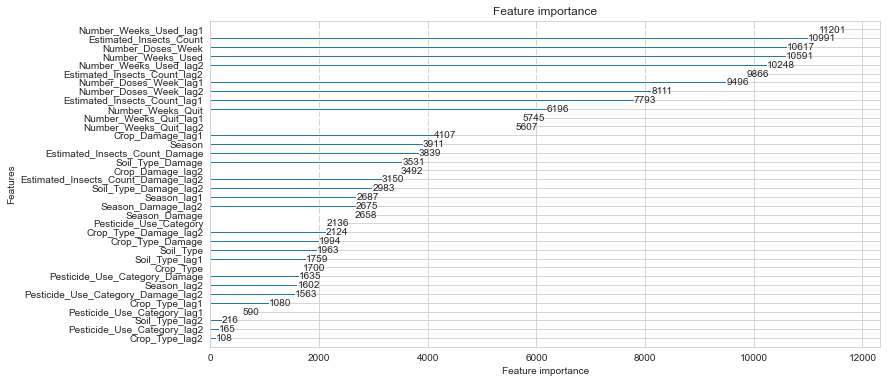

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6)
lgb.plot_importance(clf)
plt.show()

In [ ]:
## some hard-coding done in excel for marginal probability values to improve accuracy (by ~ 0.005).